In [1]:
%%capture
!pip install datasets torchvision
!pip install git+https://github.com/huggingface/transformers

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_json('/content/drive/MyDrive/HN/M2/phil_comp/odil-data-master-hn/data/image_indexing_modified.json')

In [5]:
filtro = (df['files'].str[-3:] =='jpg') | (df['files'].str[-3:] =='JPG')
df = df[filtro]

In [6]:
columns_to_keep = ['files'] + [col for col in df.columns if col[-4:] == 'term' and col!='thema_term']
df = df[columns_to_keep]

In [7]:
df = df.dropna()

In [8]:
import json
with open('/content/drive/MyDrive/HN/M2/phil_comp/odil-data-master-hn/data/translated_terms.json') as f:
  dictionary = json.load(f)

In [9]:
import unicodedata

def normalize_text(text):
    # Normalizza unicode (NFKC), rimuove escape, unifica apici
    text = unicodedata.normalize('NFKC', text)
    text = text.replace('\\', '')
    text = text.replace('“', "'").replace('”', "'").replace('"', "'")
    text = text.replace("’", "'").replace("`", "'")
    return text.strip()

def process_dataframe(df, dictionary):
    # Normalizza le chiavi del dizionario
    normalized_dict = {normalize_text(k): v for k, v in dictionary.items()}

    def map_and_concat(row):
        result = []
        for col in ['nature_place_term', 'object_architecture_term', 'character_term', 'subject_term']:
            value = row[col]
            if isinstance(value, list):
                mapped = [normalized_dict[normalize_text(item)] for item in value]
                result.extend(mapped)
        return ', '.join(result)

    df['processed_terms'] = df.apply(map_and_concat, axis=1)
    return df

In [10]:
df = df.replace('Joab tuant Absalom', 'Joab tué Absalom')
df = df.replace('gahom/Pierpont m805.105r.jpg', 'gahom/Pierpont_m805.105r.jpg')
df = df.replace('gahom/Pierpont m805.109r.jpg', 'gahom/Pierpont_m805.109r.jpg')
df = process_dataframe(df, dictionary)

In [11]:
df = df[['files', 'processed_terms']]

In [12]:
from sklearn.model_selection import train_test_split

# Split 80% train / 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
from datasets import Dataset, DatasetDict, Features, Value, Image
import os

In [14]:
#from PIL import Image

In [15]:
os.chdir('/content/drive/MyDrive/HN/M2/phil_comp/odil-data-master-hn')

In [16]:
features = Features({
    "files": Image(),  # lazy loading
    "processed_terms": Value(dtype="string")
})

In [17]:
train_dataset = Dataset.from_pandas(train_df,
                                    features=features,
                                    preserve_index=False)

In [18]:
test_dataset = Dataset.from_pandas(test_df, features=features, preserve_index=False)

In [19]:
#from PIL import Image
#def load_images(example):
 #   example["files"] = Image.open(example["files"]).convert("RGB")
  #  return example

#train_dataset = train_dataset.map(load_images)
#test_dataset = test_dataset.map(load_images)

# Crea DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Load model

In [20]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [21]:
def run_example(task_prompt, text_input, image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

In [22]:
task ="<MORE_DETAILED_CAPTION>"

Generated Description: {'<MORE_DETAILED_CAPTION>': 'The image is a square illustration with a red border and a white background. It is divided into three sections. \n\nThe top section shows a man with a beard and a red robe, holding a sword in his right hand and a staff in his left hand. He is standing on a pedestal with a green pole in front of him. The man is wearing a red cloak and has a crown of thorns on his head. He appears to be in the middle of a battle, as he is holding the pole with both hands.\n\nIn the center of the image, there is a tree with green leaves. The tree is surrounded by four figures, two of whom are holding swords and one of whom is holding a shield. The figures are dressed in medieval-style clothing and appear to be engaged in a fierce battle. The background is a light beige color, and the overall style of the illustration is ornate and detailed.'}


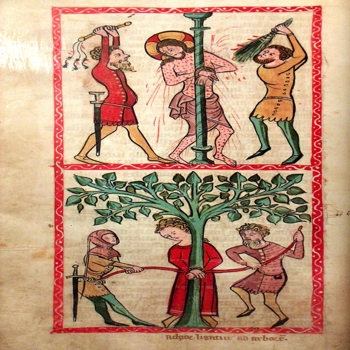

Generated Description: {'<MORE_DETAILED_CAPTION>': 'The image is a set of four panels, each with a colorful and intricate design. The panels are arranged in a grid-like pattern, with each panel having a different color and pattern.\n\nThe first panel on the top left shows a group of people gathered around a central figure, which appears to be a deity or a deity. The figure is wearing a red robe and is holding a staff in one hand and a book in the other. The second panel in the middle shows a large group of figures, including angels, saints, and other religious figures. The figures are dressed in colorful robes and are gathered in a circle, with some standing and others sitting. The background of the panels is a mix of red, orange, and yellow, with a black border around the edges. The overall style of the painting is reminiscent of medieval or religious art, with bold lines and bright colors.'}


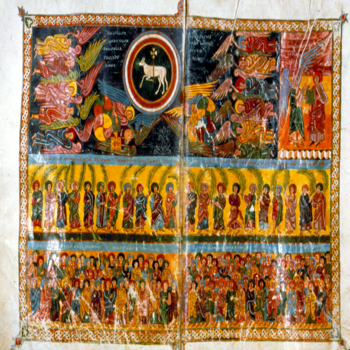

In [23]:
for idx in range(2):
    image = dataset_dict['train'][idx]['files']
    description = run_example(task, '', image)
    print(f"Generated Description: {description}")
    display(image.resize([350, 350]))

# Finetuning

In [24]:
from torch.utils.data import Dataset

class MedievalIllustration(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        prompt = "<MORE_DETAILED_CAPTION>"
        description = example['processed_terms']
        image = example['files']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return prompt, description, image

In [25]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

In [26]:
train_dataset = MedievalIllustration(dataset_dict['train'])
test_dataset = MedievalIllustration(dataset_dict['test'])

In [27]:
def collate_fn(batch):
    prompts, descriptions, images = zip(*batch)
    inputs = processor(text=list(prompts), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, descriptions

# Create DataLoader
batch_size = 6  #6
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [28]:
from transformers import get_scheduler
from torch.optim import AdamW

In [48]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs, descriptions = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=list(descriptions), return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, descriptions = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=list(descriptions), return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

In [49]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

train_model(train_loader, test_loader, model, processor, epochs=10, lr=1e-6)

Training Epoch 1/10: 100%|██████████| 618/618 [30:29<00:00,  2.96s/it]


Average Training Loss: 3.3201817133280067


Validation Epoch 1/10: 100%|██████████| 155/155 [06:25<00:00,  2.49s/it]


Average Validation Loss: 1.7900596664797874


Training Epoch 2/10: 100%|██████████| 618/618 [12:20<00:00,  1.20s/it]


Average Training Loss: 1.5986225609833369


Validation Epoch 2/10: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.3639867351901147


Training Epoch 3/10: 100%|██████████| 618/618 [12:21<00:00,  1.20s/it]


Average Training Loss: 1.3505599600983282


Validation Epoch 3/10: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.2474911639767308


Training Epoch 4/10: 100%|██████████| 618/618 [12:21<00:00,  1.20s/it]


Average Training Loss: 1.246038391848598


Validation Epoch 4/10: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.189827621752216


Training Epoch 5/10: 100%|██████████| 618/618 [12:21<00:00,  1.20s/it]


Average Training Loss: 1.1846706552798694


Validation Epoch 5/10: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.150224470707678


Training Epoch 6/10: 100%|██████████| 618/618 [12:21<00:00,  1.20s/it]


Average Training Loss: 1.1348819388347922


Validation Epoch 6/10: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.1257727976768248


Training Epoch 7/10:  66%|██████▋   | 410/618 [08:13<04:10,  1.20s/it]


KeyboardInterrupt: 

Generated Description: {'<MORE_DETAILED_CAPTION>': 'tree, fountain, sword, armor, shield, coat of arms, helmet, armor of the Roman soldier, Vierge'}


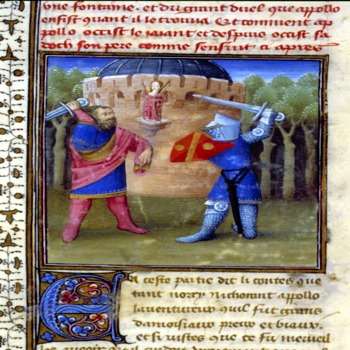

Generated Description: {'<MORE_DETAILED_CAPTION>': 'eagle, star, tree, grass, staff, seat (furniture), architecture, staircase, child, God, Vierge, Saint Joseph, adoration of the magi'}


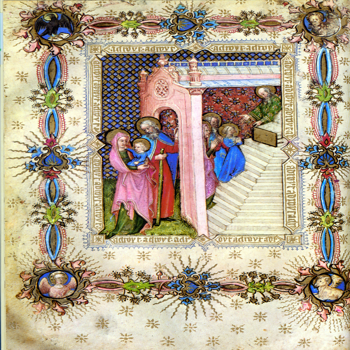

In [52]:
model.eval()
for idx in range(2):
    image = dataset_dict['test'][idx]['files']
    description = run_example(task, '', image)
    print(f"Generated Description: {description}")
    display(image.resize([350, 350]))

Original_desctiption: forest, shoot, statue, idol, sword, armor, shield, helm, coat of arms, arcade, capital, knight, Venus


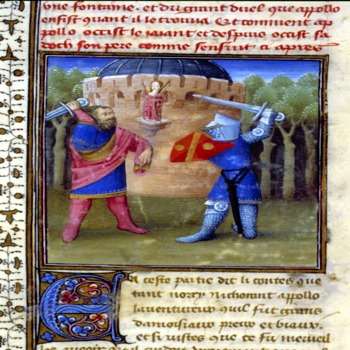

Original_desctiption: lion, ox, eagle, staff, altar, staircase, Hebrew priest, angel, Saint Anne, Saint Joachim, Vierge, St. John, Saint Mark, Saint Matthew, Saint Luke, evangelists-4 zoamorphes, presentation of the Virgin at the temple


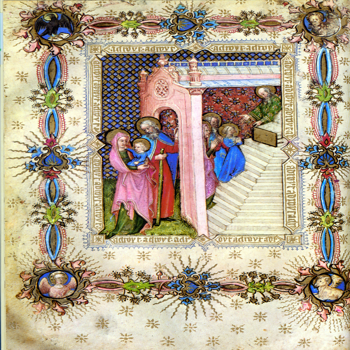

In [53]:
for idx in range(2):
    image = dataset_dict['test'][idx]['files']
    description = dataset_dict['test'][idx]['processed_terms']
    print(f"Original_desctiption: {description}")
    display(image.resize([350, 350]))

In [54]:
from huggingface_hub import notebook_login

notebook_login()

In [55]:
model.config.vision_config.model_type = 'davit'

In [56]:
model.push_to_hub('francipaolo/florence-2-pal-comp-v1',private=True)
processor.push_to_hub('francipaolo/florence-2-pal-comp-v1', private=True)

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/francipaolo/florence-2-pal-comp-v1/commit/ead223112cebd235f2552118588d9728d6e71d23', commit_message='Upload processor', commit_description='', oid='ead223112cebd235f2552118588d9728d6e71d23', pr_url=None, repo_url=RepoUrl('https://huggingface.co/francipaolo/florence-2-pal-comp-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='francipaolo/florence-2-pal-comp-v1'), pr_revision=None, pr_num=None)